Check Average Prices and School Ratings

Step 1 - Python packages and Dependencies

In [13]:
import requests
import json # library to handle JSON files
import xml
import pandas as pd #Python library data manipulation and analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
%matplotlib inline

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import warnings
warnings.filterwarnings("ignore")

Step 2 - Import Data

In [105]:
df=pd.read_csv('Toronto.TASK_II_df.csv')
print(df.shape)
df.rename(columns={'Neighbourhood':'Neighborhood','Postal Code':'Postalcode'}, inplace=True)
df.head(5)

(103, 5)


,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [75]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of Seattle,Washington are 43.773077, -79.257774.


Step3 - Map Scarborough Canada

In [78]:
# create map of Toronto using latitude and longitude values
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

# add markers to map
for lat, lng, nei in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [53]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The geograpical coordinate of neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of neighborhood_1 are 43.773077, -79.257774.


In [54]:
CLIENT_ID = '' 
CLIENT_SECRET = '' 
VERSION = '20200222' 

In [91]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [92]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.events.count', 'venue.events.summary', 'venue.id',
       'venue.location.address', 'venue.location.cc', 'venue.location.city',
       'venue.location.country', 'venue.location.crossStreet',
       'venue.location.distance', 'venue.location.formattedAddress',
       'venue.location.labeledLatLngs', 'venue.location.lat',
       'venue.location.lng', 'venue.location.neighborhood',
       'venue.location.postalCode', 'venue.location.state', 'venue.name',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [93]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Step4 - Venues Nearby

In [94]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head(5)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
2,American Eagle Outfitters,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
3,Hot Topic,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.775450,-79.257929
4,Canyon Creek Chophouse,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",43.776959,-79.261694


Steps5 - Categories of Nearby Venues

In [95]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,SEPHORA,Cosmetics Shop,43.775017,-79.258109
2,American Eagle Outfitters,Clothing Store,43.776012,-79.258334
3,Hot Topic,Clothing Store,43.775450,-79.257929
4,Canyon Creek Chophouse,Steakhouse,43.776959,-79.261694


In [96]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store    8
Coffee Shop       5
Restaurant        3
Tea Room          2
Pharmacy          2
Wings Joint       2
Cosmetics Shop    2
Gas Station       2
Sandwich Place    2
Steakhouse        1
Name: categories, dtype: int64

In [97]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [57]:

# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )



Malvern, Rouge
Highland Creek, Port Union, Rouge Hill
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South, Flemingdon Park
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
Riverdale, The Danf

In [98]:


print('There are {} uniques categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()



There are 320 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,7,7,7,7,7,7
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",18,18,18,18,18,18
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",12,12,12,12,12,12
"Alderwood, Long Branch",14,14,14,14,14,14


One Hot Encoding of Features

In [99]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sp

In [100]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0       Coffee Shop  0.07
1              Café  0.06
2  Sushi Restaurant  0.04
3        Steakhouse  0.03
4               Gym  0.03


----Agincourt----
                       venue  freq
0                  Pool Hall  0.14
1        Shanghai Restaurant  0.14
2             Sandwich Place  0.14
3  Latin American Restaurant  0.14
4                     Lounge  0.14


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                  venue  freq
0  Fast Food Restaurant  0.11
1          Noodle House  0.11
2           Pizza Place  0.11
3    Chinese Restaurant  0.11
4                   Gym  0.06


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                  venue  freq
0         Grocery Store  0.17
1  Caribbean Restaurant  0.08
2        Hardware Store  0.08
3        Sandwich Place  0.08
4   Fried Chicken Joint  0.08


----Alderwood, Long Branch----
 

               venue  freq
0        Coffee Shop  0.10
1  Convenience Store  0.06
2               Café  0.06
3        Pizza Place  0.06
4         Restaurant  0.03


----Emery, Humberlea----
               venue  freq
0     Discount Store  0.25
1        Gas Station  0.25
2  Convenience Store  0.25
3     Baseball Field  0.25
4        Music Venue  0.00


----Fairview, Henry Farm, Oriole----
                  venue  freq
0        Clothing Store  0.11
1           Coffee Shop  0.08
2  Fast Food Restaurant  0.06
3   Japanese Restaurant  0.05
4        Baseball Field  0.05


----First Canadian Place, Underground city----
         venue  freq
0  Coffee Shop  0.09
1         Café  0.07
2          Bar  0.04
3        Hotel  0.04
4   Steakhouse  0.04


----Forest Hill North, Forest Hill West----
                  venue  freq
0  Gym / Fitness Center   0.4
1         Jewelry Store   0.2
2                 Trail   0.2
3      Sushi Restaurant   0.2
4           Yoga Studio   0.0


----Garden District, Ryerso

          venue  freq
0          Park   0.6
1    Playground   0.2
2         Trail   0.2
3   Yoga Studio   0.0
4  Music School   0.0


----Roselawn----
           venue  freq
0           Pool  0.14
1            Spa  0.14
2         Garden  0.14
3  Moving Target  0.14
4      Pet Store  0.14


----Runnymede, Swansea----
                venue  freq
0                Café  0.09
1         Pizza Place  0.06
2         Coffee Shop  0.06
3  Italian Restaurant  0.05
4    Sushi Restaurant  0.03


----Runnymede, The Junction North----
                venue  freq
0         Pizza Place  0.14
1                Park  0.10
2         Coffee Shop  0.10
3             Brewery  0.10
4  Athletics & Sports  0.10


----Scarborough Village----
                  venue  freq
0        Ice Cream Shop  0.33
1  Fast Food Restaurant  0.17
2           Coffee Shop  0.17
3           Pizza Place  0.17
4     Convenience Store  0.17


----Silver Hills, York Mills----
          venue  freq
0     Cafeteria   1.0
1   Yoga Studio  

In [101]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Most Common venues near neighborhood

In [102]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Sushi Restaurant,Restaurant,Cosmetics Shop,Steakhouse,Thai Restaurant,Theater,Bar,Gym
1,Agincourt,Sandwich Place,Badminton Court,Breakfast Spot,Pool Hall,Shanghai Restaurant,Lounge,Latin American Restaurant,Donut Shop,Diner,Discount Store
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Fast Food Restaurant,Chinese Restaurant,Pizza Place,Noodle House,Malay Restaurant,Shop & Service,Food Court,Japanese Restaurant,Bakery,Caribbean Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Fast Food Restaurant,Coffee Shop,Pharmacy,Caribbean Restaurant,Sandwich Place,Beer Store,Fried Chicken Joint,Pizza Place,Gym Pool
4,"Alderwood, Long Branch",Pizza Place,Convenience Store,Coffee Shop,Pub,Sandwich Place,Athletics & Sports,Gas Station,Skating Rink,Dance Studio,Pharmacy


k-means Clustering

In [132]:
# set number of clusters
# Using k-means to cluster the neighborhood into 3 clusters.

Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
#Scarborough_grouped_clustering = Scarborough_grouped

# set number of clusters
kclusters = 3
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Scarborough_grouped_clustering)
#kmeans.to_numpy()
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2], dtype=int32)

In [154]:

Scarborough_merged =df.iloc[:16,:]

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!


,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [153]:
Scarborough_merged

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [141]:
Scarborough_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 16 columns):
Postalcode                16 non-null object
Borough                   16 non-null object
Neighborhood              16 non-null object
Latitude                  16 non-null float64
Longitude                 16 non-null float64
Cluster Labels            16 non-null int32
1st Most Common Venue     16 non-null object
2nd Most Common Venue     16 non-null object
3rd Most Common Venue     16 non-null object
4th Most Common Venue     16 non-null object
5th Most Common Venue     16 non-null object
6th Most Common Venue     16 non-null object
7th Most Common Venue     16 non-null object
8th Most Common Venue     16 non-null object
9th Most Common Venue     16 non-null object
10th Most Common Venue    16 non-null object
dtypes: float64(2), int32(1), object(13)
memory usage: 2.0+ KB


In [142]:
# Dropping the row with the NaN value 
Scarborough_merged.dropna(inplace = True)

In [143]:
Scarborough_merged.shape

(16, 16)

In [144]:
Scarborough_merged['Cluster Labels'] = Scarborough_merged['Cluster Labels'].astype(int)

In [148]:


# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Scarborough_merged['Latitude'], Scarborough_merged['Longitude'], Scarborough_merged['Neighborhood'], Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters



In [149]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

Average Housing Prices

In [156]:

df1 = df.head(17)
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df1["Neighborhood"],"Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,279200.0,225000.0,370500.,255400.0,433500.0,433500.0]})

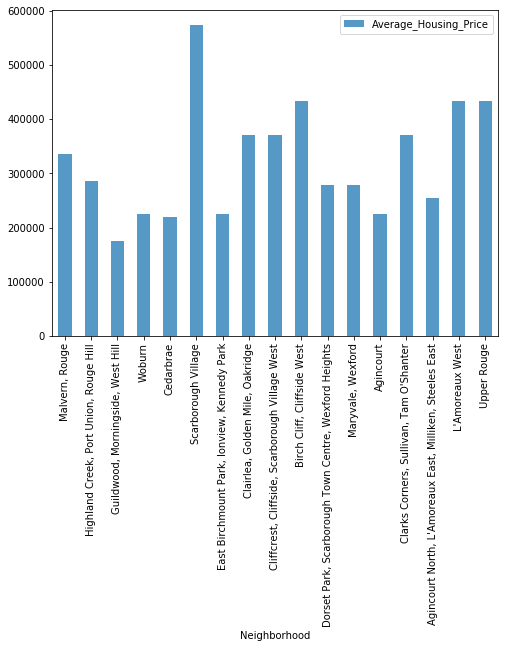

In [157]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(8,6),alpha=0.75)


Conclusion:

In this project, through a k-means cluster algorithm we separate the neighborhood into 03 clusters, which have similar neighborhoods around them. Using the charts above decision loving to a particular neighborhood based on average house prices can be made
